In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from time import process_time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
data = []

for root, subdirs, files in os.walk('../dataset/training_set'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

In [3]:
print(data[0])

('arrow', array([[-1.98115675,  1.98053787],
       [-2.06546475,  1.99436522],
       [-1.93086964,  1.8442288 ],
       [-1.90192736,  1.76971743],
       [-1.78875077,  1.71317545],
       [-1.71781591,  1.57516255],
       [-1.57514812,  1.43563976],
       [-1.58042064,  1.39580667],
       [-1.34995696,  1.18830922],
       [-1.19546419,  0.99642441],
       [-0.960359  ,  0.83813815],
       [-0.78288021,  0.61858763],
       [-0.52384061,  0.46002859],
       [-0.32284315,  0.28639652],
       [-0.08225056,  0.0972638 ],
       [ 0.13539409, -0.04098562],
       [ 0.28665714, -0.18479149],
       [ 0.38552463, -0.22181367],
       [ 0.54906291, -0.37553448],
       [ 0.62910992, -0.43764128],
       [ 0.77023395, -0.53465178],
       [ 0.81775568, -0.56226704],
       [ 0.89772108, -0.61428591],
       [ 0.7960657 , -0.65419655],
       [ 0.7157478 , -0.69746153],
       [ 0.5429837 , -0.65135589],
       [ 0.34374538, -0.64974188],
       [ 0.22664267, -0.6529458 ],
       [ 0

In [4]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'x', 'question_mark', 'triangle', 'left_curly_brace', 'caret', 'arrow', 'rectangle', 'right_curly_brace', 'delete_mark', 'left_sq_bracket', 'star', 'pigtail', 'right_sq_bracket', 'v', 'circle', 'check'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16)


In [5]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates
model.add(LSTM(8, input_shape=(NUM_POINTS, 2)))

# add dense layer to do machine learning magic
model.add(Dense(8, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [6]:
# Train the model
train_start = process_time()
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)
train_end = process_time()

Epoch 1/50
128/128 [==============================] - 3s 12ms/step - loss: 2.6148 - accuracy: 0.2703 - val_loss: 2.4035 - val_accuracy: 0.3701 - lr: 0.0010
Epoch 2/50
128/128 [==============================] - 1s 8ms/step - loss: 2.1647 - accuracy: 0.3821 - val_loss: 1.8706 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 3/50
128/128 [==============================] - 1s 8ms/step - loss: 1.7002 - accuracy: 0.4612 - val_loss: 1.4996 - val_accuracy: 0.4814 - lr: 0.0010
Epoch 4/50
128/128 [==============================] - 1s 7ms/step - loss: 1.4001 - accuracy: 0.5369 - val_loss: 1.2663 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 5/50
128/128 [==============================] - 1s 8ms/step - loss: 1.1728 - accuracy: 0.6299 - val_loss: 1.0391 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 6/50
128/128 [==============================] - 1s 8ms/step - loss: 0.9726 - accuracy: 0.7163 - val_loss: 0.8812 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 7/50
128/128 [==============================] - 1s 8ms/step - l

In [7]:
train_end

132.874585065

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 352       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
Total params: 568
Trainable params: 568
Non-trainable params: 0
_________________________________________________________________


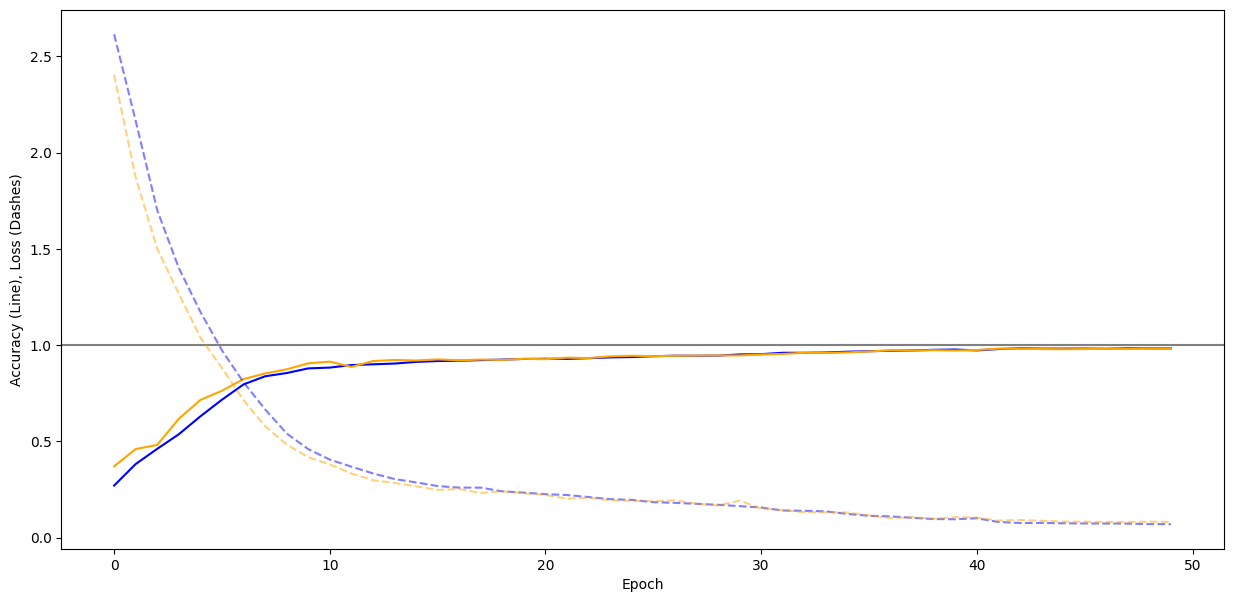

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## Testing the model with dataset/test_set

The test_set is a subset of xml_logs (specifically xml_logs/s01/slow) and consists of ten gestures from each class.

This subset was excluded from training.

In [10]:
test_data = []

for root, subdirs, files in os.walk('../dataset/test_set'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                test_data.append((label, resampled))

In [11]:
# Prepare the data
test_labels = [sample[0] for sample in test_data]

print(set(test_labels))

encoder = LabelEncoder()
test_labels_encoded = encoder.fit_transform(test_labels)

print(set(test_labels_encoded))

y_test = to_categorical(test_labels_encoded)

print(len(y_test[0]))

sequences = [sample[1] for sample in test_data]
X_test = np.array(sequences)

{'x', 'question_mark', 'triangle', 'left_curly_brace', 'caret', 'arrow', 'rectangle', 'right_curly_brace', 'delete_mark', 'left_sq_bracket', 'pigtail', 'star', 'right_sq_bracket', 'v', 'circle', 'check'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16


5/5 [==============================] - 0s 3ms/step


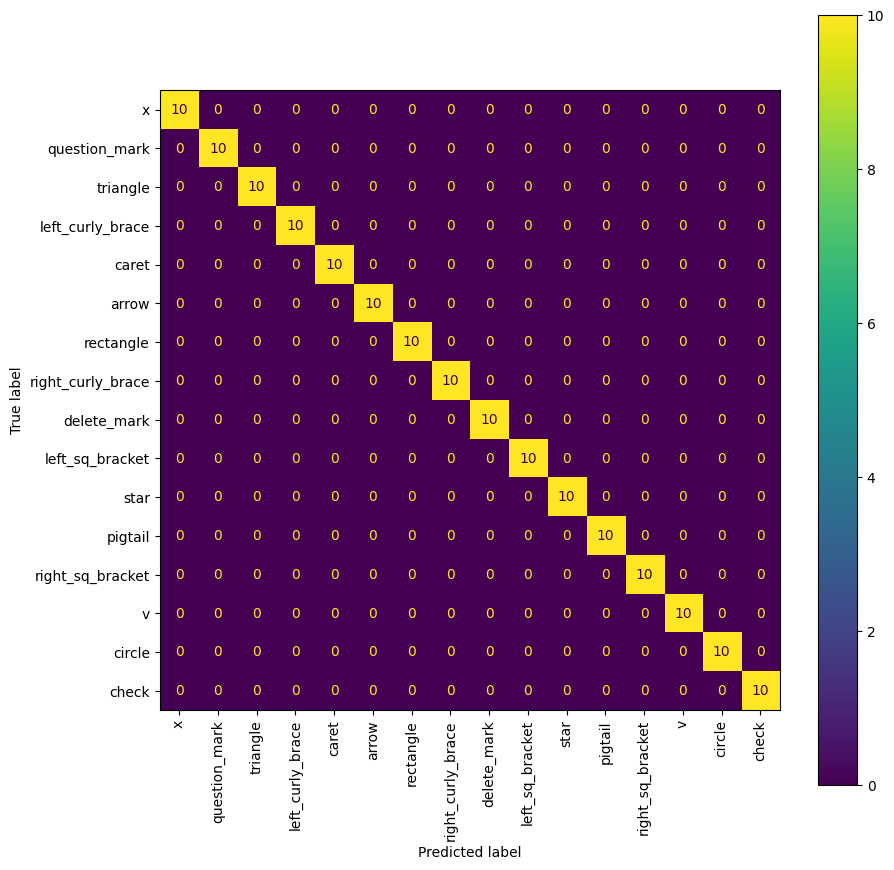

In [12]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [13]:
single_sample = np.reshape(X_test[0], (1,NUM_POINTS,2))

In [14]:
%%timeit
single_prediction = model.predict(single_sample)

1/1 [==============================] - 0s 15ms/step
34 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


1/1 [==============================] - 0s 13ms/step
Label:      pigtail
Prediction: pigtail


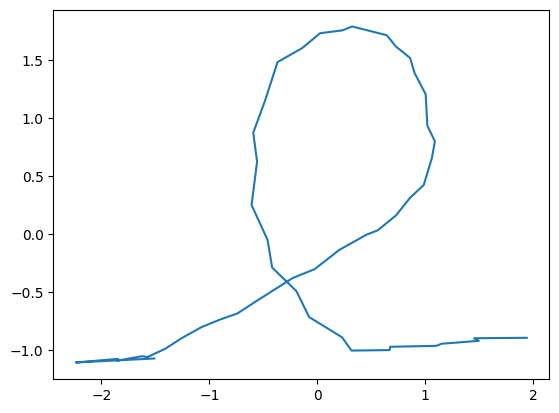

In [15]:
# lets test the model in action

test_data_new = random.sample(test_data, 1)[0]

label = test_data_new[0]
sequence = test_data_new[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)

In [16]:
from recognizer import Recognizer

In [17]:
recognizer = Recognizer()
test_set = []

In [19]:
for root, subdirs, files in os.walk('../dataset/test_set'):
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]

                xml_root = ET.parse(f'{root}/{f}').getroot()

                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])

                points = np.array(points, dtype=float)

                test_set.append((label, points))

In [20]:
counter = 0
for xml in test_set:
    result = recognizer.recognize(xml[1])
    ground_truth = xml[0]
    prediction = result
    if ground_truth == prediction:
        counter += 1

In [21]:
print(f'{counter/len(test_set)} predictions correct')

0.90625 predictions correct


In [27]:
%%timeit
recognizer.recognize(test_set[0][1])

13.6 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 

## Model performance dependancy on parameter count

The parameter count was gradually decreased by tweaking the amount of nodes in the LSTM and Dense layer.

The accuracy and prediction times for different settings were logged to raw_data.csv

## Disclaimer

The training was caped to 50 epochs, but this limit was rarely reached. This means models with fewer trainable parameters might not have reached their full potential regarding accuracy.

The implementation of the 1$ recognizer is bugged, which means the real accuracy is expected to be different.

## Summary

<u>Version 1:</u>

LSTM (64 nodes), Dense (32 nodes):

Number of trainable parameters:

19,760

Mean accuracy over 10 training session:

Acc: 0.99753, Val_Acc: 0.99423

Mean prediction time over 70 predictions:

35.3 ms

<u>Version 2:</u>

LSTM (32 nodes), Dense (16 nodes):

Number of trainable parameters:

5,280

Mean accuracy over 10 training session:

Acc: 0.99573, Val_Acc: 0.99267	

Mean prediction time over 70 predictions:

35.1 ms

<u>Version 3:</u>

LSTM (16 nodes), Dense (16 nodes):

Number of trainable parameters:

1,760

Mean accuracy over 10 training session:

Acc: 0.98976, Val_Acc: 0.98780	

Mean prediction time over 70 predictions:

35.1 ms

<u>Version 4:</u>

LSTM (8 nodes), Dense (16 nodes):

Number of trainable parameters:

768

Mean accuracy over 10 training session:

Acc: 0.98399, Val_Acc: 0.98165	

Mean prediction time over 70 predictions:

35.1 ms

<u>Version 5:</u>

LSTM (8 nodes), Dense (8 nodes):

Number of trainable parameters:

568

Mean accuracy over 10 training session:

Acc: 0.98308, Val_Acc: 0.97764

Mean prediction time over 70 predictions:

35.1 ms

<u>Version 5:</u>

1$ recognizer

Accuracy:

0.90625

Mean prediction time over 700 predictions:

13.6 ms

## Findings

Decreasing the number of trainable parameters doesn't seem to affect the models accuracy and prediction time. It increases the number of epochs and overall training time needed.

The one dollar recognizer performs worse accuracy wise, but prediction times seem to be faster.

Based on these findings the recommended method is dependend on the type of real life application. Application which don't heavily depend on accuracy should use the one dollar recognizer. In applications, where the correctness of the prediction is critical, a lstm implementation seems more appropriate.

In [23]:
import pandas as pd

In [24]:
df = pd.read_csv('./results/raw.csv')
df = df.drop(columns='Attempt')
grouped = df.groupby('Label').mean()

In [25]:
grouped

,Accuracy,Val_accuracy,Time (s)
Label,,,
(16/16),0.98976,0.98780,55.319
(32/16),0.99573,0.99267,58.743
(64/32),0.99753,0.99423,74.250
(8/16),0.98399,0.98165,111.319
(8/8),0.98308,0.97764,120.844
